<a href="https://colab.research.google.com/github/unninakul/meat-quality-assessment/blob/main/Meat_Quality_Analysis_using_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#import modules
import tensorflow as tf
import numpy as np
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt


In [2]:
from google.colab import drive

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#Image Conversion
import os
from PIL import Image

folder_path = "/content/drive/MyDrive/meat data.file.zip (Unzipped Files)"
file_list = os.listdir(folder_path)

for file_name in file_list:
    if file_name.lower().endswith((".png", ".jpg", ".jpeg")):
        file_path = os.path.join(folder_path, file_name)

        try:
            image = Image.open(file_path)
        except Exception as e:
            print(f"Error opening {file_name}: {str(e)}")
            continue

        new_file_path = os.path.splitext(file_path)[0] + ".jpg"

        try:
            image.save(new_file_path, "JPEG")
        except Exception as e:
            print(f"Error converting {file_name} to JPEG: {str(e)}")
            continue

        os.remove(file_path)
        os.rename(new_file_path, file_path)
        print(f"{file_name} converted to JPEG and replaced successfully.")

IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 30


In [5]:
#Importing Dataset
import tensorflow as tf

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/meat data.file.zip (Unzipped Files)",
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
)


Found 1896 files belonging to 2 classes.


In [6]:
#Data Preperation
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

print(image_batch[0].numpy())
print(image_batch[0])
print(image_batch[0].shape)


(32, 256, 256, 3)
[0 0 1 0 1 1 1 1 1 0 0 0 1 1 1 1 0 0 0 1 0 1 0 0 1 1 0 0 0 1 1 0]
[[[119.09375 126.09375 119.09375]
  [117.625   124.625   117.625  ]
  [101.84375 108.84375 101.84375]
  ...
  [192.      252.      250.     ]
  [188.09375 248.09375 246.09375]
  [191.      251.      249.     ]]

 [[115.5625  122.5625  115.5625 ]
  [109.25    116.25    109.25   ]
  [124.84375 131.84375 124.84375]
  ...
  [187.5625  249.      246.28125]
  [186.5625  248.      245.28125]
  [188.5625  250.      247.28125]]

 [[118.0625  125.0625  118.0625 ]
  [230.84375 236.25    230.84375]
  [178.28125 184.34375 178.28125]
  ...
  [184.46875 246.46875 243.46875]
  [185.      247.      244.     ]
  [187.      249.      246.     ]]

 ...

 [[236.      248.      246.     ]
  [236.      248.      246.     ]
  [236.      248.      246.     ]
  ...
  [136.46875 223.46875 206.46875]
  [137.0625  224.0625  207.0625 ]
  [139.53125 226.53125 209.53125]]

 [[236.      248.      246.     ]
  [236.      248.      246. 

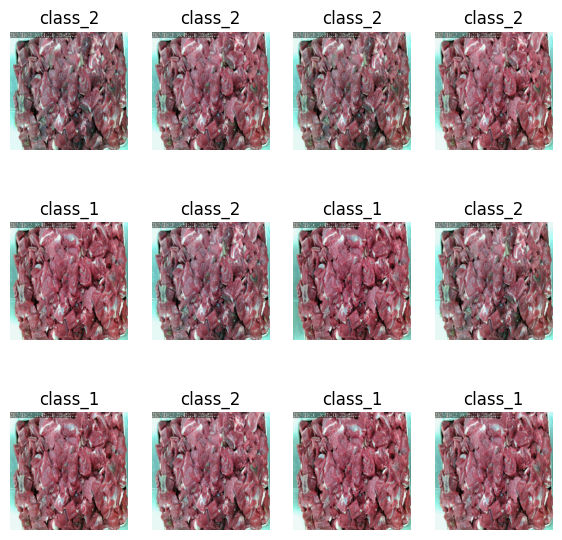

In [7]:
#Data Exploration
plt.figure(figsize=(7, 7))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        class_names = ['class_1', 'class_2', 'class_3', ...]
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [8]:
#Splitting the Dataset
import tensorflow as tf
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1,
                              shuffle=True, shuffle_size=10000):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    remaining_ds = ds.skip(train_size)
    val_ds = remaining_ds.take(val_size)
    test_ds = remaining_ds.skip(val_size)

    return train_ds, val_ds, test_ds

train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)
print(len(train_ds))
print(len(val_ds))
print(len(test_ds))

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)


48
6
6


In [9]:
#Image Preprocessing
import tensorflow as tf
from tensorflow.keras import layers
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0 / 255)
])
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.Rescaling(0.2),
    layers.experimental.preprocessing.RandomContrast(factor=0.2),
    layers.experimental.preprocessing.RandomZoom(0.2)
])

In [10]:
#Defining a CNN Model
from tensorflow.keras import models, layers
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])
model.build(input_shape=(None, *input_shape))
model.summary()




Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                 

In [11]:
#Compiling the Model
model.compile(
optimizer='adam',
loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
metrics=['accuracy']
)

In [12]:
#Training the Model
from tensorflow.keras.callbacks import EarlyStopping
early_stopping=tf.keras.callbacks.EarlyStopping(patience=3)
history=model.fit(
train_ds,
epochs=EPOCHS,
                   batch_size=BATCH_SIZE,
verbose=1,
validation_data=val_ds
)



Epoch 1/30
48/48 [==============================] - 533s 6s/step - loss: 0.7372 - accuracy: 0.4980 - val_loss: 0.7090 - val_accuracy: 0.4375
Epoch 2/30
48/48 [==============================] - 251s 5s/step - loss: 0.6962 - accuracy: 0.5225 - val_loss: 0.6845 - val_accuracy: 0.5625
Epoch 3/30
48/48 [==============================] - 254s 5s/step - loss: 0.6960 - accuracy: 0.5337 - val_loss: 0.6887 - val_accuracy: 0.5625
Epoch 4/30
48/48 [==============================] - 252s 5s/step - loss: 0.6938 - accuracy: 0.5245 - val_loss: 0.6713 - val_accuracy: 0.5625
Epoch 5/30
48/48 [==============================] - 261s 5s/step - loss: 0.5634 - accuracy: 0.6693 - val_loss: 0.0696 - val_accuracy: 0.9948
Epoch 6/30
48/48 [==============================] - 252s 5s/step - loss: 0.3125 - accuracy: 0.8717 - val_loss: 0.0365 - val_accuracy: 0.9792
Epoch 7/30
48/48 [==============================] - 246s 5s/step - loss: 0.1094 - accuracy: 0.9504 - val_loss: 0.0524 - val_accuracy: 0.9792
Epoch 8/30
48

In [13]:
#Testing the Model
scores=model.evaluate(test_ds)
scores

6/6 [==============================] - 24s 2s/step - loss: 0.0559 - accuracy: 0.9583


[0.05586925521492958, 0.9583333134651184]